In [10]:
import pandas as pd
import numpy as np
import os
import itertools
import matplotlib.pyplot as plt
from matplotlib import rcParams, gridspec
from pandas.api.types import CategoricalDtype
import pickle

import sklearn
from sklearn import model_selection
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn import metrics
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score

os.chdir("/Users/kelsey.huntzberry/Documents/Classes/Machine_Learning_Class/Data")
print(os.getcwd())

/Users/kelsey.huntzberry/Documents/Classes/Machine_Learning_Class/Data


In [2]:
import gc
gc.collect()

31

In [4]:
# Read in Treatment Episode Data Set data
teds18 = pd.read_csv('tedsa_puf_2018.csv')

In [5]:
teds18.columns

Index(['ADMYR', 'CASEID', 'STFIPS', 'CBSA2010', 'EDUC', 'MARSTAT', 'SERVICES',
       'DETCRIM', 'NOPRIOR', 'PSOURCE', 'ARRESTS', 'EMPLOY', 'METHUSE',
       'PSYPROB', 'PREG', 'GENDER', 'VET', 'LIVARAG', 'DAYWAIT', 'DSMCRIT',
       'AGE', 'RACE', 'ETHNIC', 'DETNLF', 'PRIMINC', 'SUB1', 'SUB2', 'SUB3',
       'ROUTE1', 'ROUTE2', 'ROUTE3', 'FREQ1', 'FREQ2', 'FREQ3', 'FRSTUSE1',
       'FRSTUSE2', 'FRSTUSE3', 'HLTHINS', 'PRIMPAY', 'FREQ_ATND_SELF_HELP',
       'ALCFLG', 'COKEFLG', 'MARFLG', 'HERFLG', 'METHFLG', 'OPSYNFLG',
       'PCPFLG', 'HALLFLG', 'MTHAMFLG', 'AMPHFLG', 'STIMFLG', 'BENZFLG',
       'TRNQFLG', 'BARBFLG', 'SEDHPFLG', 'INHFLG', 'OTCFLG', 'OTHERFLG',
       'DIVISION', 'REGION', 'IDU', 'ALCDRUG'],
      dtype='object')

In [6]:
# Subset the data to just the 0/1 drug flag variables
flags = teds18.filter(regex='FLG$', axis = 1)

In [7]:
# Sum the flag variables to calculate the number of drugs recorded for each individual
NUMSUBS = flags.sum(axis=1)

In [8]:
# Concatenate flag variables back into the 2015-17 data
teds_wflgs = pd.concat([teds18, NUMSUBS], axis = 1)
teds_wflgs.rename(columns={0:'NUMSUBS'}, inplace = True)

In [9]:
# Remove rows where the first substance was "None"
teds_sm_temp = teds_wflgs[teds_wflgs.SUB1 != 1]
# Remove rows where number of prior treatments is NA (target variable)
teds_sm1 = teds_sm_temp[teds_sm_temp.NOPRIOR != -9]

In [10]:
# Select subset of columns
teds_sm = teds_sm1.loc[:,['CASEID','ADMYR','AGE','GENDER','RACE','ETHNIC','EDUC','EMPLOY','VET','LIVARAG',\
                          'STFIPS','CBSA2010','DIVISION','REGION','SERVICES','PSOURCE','NOPRIOR','ARRESTS','ROUTE1','FRSTUSE1','FREQ1', \
                          'ROUTE2','FRSTUSE2', 'FREQ2','ROUTE3','FRSTUSE3','FREQ3','NUMSUBS','METHUSE','ALCFLG','PSYPROB', \
                          'COKEFLG','MARFLG','HERFLG','METHFLG','OPSYNFLG','PCPFLG','HALLFLG','MTHAMFLG','AMPHFLG','STIMFLG', \
                          'BENZFLG','TRNQFLG','BARBFLG','SEDHPFLG','INHFLG','OTCFLG','OTHERFLG']]

In [11]:
# Recode age group variable
def age_groups(series):
    if series == 1:
        return '12_14_years'
    elif series == 2:
        return '15_17_years'
    elif series == 3:
        return '18_20_years'
    elif series == 4:
        return '21_24_years'
    elif series == 5:
        return '25_29_years'
    elif series == 6:
        return '30_34_years'
    elif series == 7:
        return '35_39_years'
    elif series == 8:
        return '40_44_years'
    elif series == 9:
        return '45_49_years'
    elif series == 10:
        return '50_54_years'
    elif series == 11:
        return '55_64_years'
    elif series == 12:
        return '65_plus_years'
    
teds_sm1.loc[:, 'age_group'] = teds_sm1.AGE.apply(age_groups)

# Change variable to an ordered factor
teds_sm1.loc[:, 'age_group'] = pd.Categorical(teds_sm1['age_group'], categories = ['12_14_years', '15_17_years', '18_20_years',
                                                                                   '21_24_years', '25_29_years', '30_34_years',
                                                                                   '35_39_years', '40_44_years', '45_49_years',
                                                                                   '50_54_years', '55_64_years', '65_plus_years'], ordered = True)

# Change variable to an ordered factor with values as numbers
labels, unique = pd.factorize(teds_sm1.loc[:, 'age_group'], sort = True)
teds_sm1.loc[:, 'age_group'] = labels

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [12]:
# Recode gender variable
def gen_rc(series):
    if series == 1:
        return 0
    elif series == 2:
        return 1
    
teds_sm1.loc[:, 'gender'] = teds_sm1.GENDER.apply(gen_rc)

In [13]:
# Recode methadone variable
def methadone_rc(series):
    if series == 1:
        return 1
    elif series == 2:
        return 0
    
teds_sm1.loc[:, 'methadone_use'] = teds_sm1.METHUSE.apply(methadone_rc)

In [14]:
def educ_rc(series):
    if series == 1:
        return 'No_Schooling'
    elif series == 2:
        return 'Grades_9_to_11'
    elif series == 3:
        return 'Grades_12_or_GED'
    elif series == 4:
        return 'College_1_to_3_years'
    elif series == 5:
        return 'College_4_or_more_years'

teds_sm1.loc[:, 'educ'] = teds_sm1.EDUC.apply(educ_rc)

# Change variable to an ordered factor
teds_sm1.loc[:, 'educ'] = pd.Categorical(teds_sm1['educ'], categories = ['No_Schooling', 'Grades_9_to_11', 'Grades_12_or_GED',
                                                                         'College_1_to_3_years', 'College_4_or_more_years'], ordered = True)

# Change variable to an ordered factor with values as numbers
labels, unique = pd.factorize(teds_sm1.loc[:, 'educ'], sort = True)
teds_sm1.loc[:, 'educ'] = labels

In [15]:
# Record race variable
def race_rc(series):
    if series == 1:
        return 'Alaska_Native'
    elif series == 2:
        return 'American_Indian'
    elif series == 3 or series == 9:
        return 'Hawaiian_Pacific_Islander'
    elif series == 4:
        return 'Black'
    elif series == 5:
        return 'White'
    elif series == 6:
        return 'Asian'
    elif series == 7:
        return 'Other_race'
    elif series == 8:
        return 'Two_or_more_races'
    
teds_sm1.loc[:, 'race'] = teds_sm1.RACE.apply(race_rc)

In [16]:
# Recode ethnicity variable
def ethnic_rc(series):
    if (series >= 1 or series <= 3) or series == 5:
        return 1
    elif series == 4:
        return 0
    
teds_sm1.loc[:, 'ethnic'] = teds_sm1.ETHNIC.apply(ethnic_rc)

In [17]:
# Recode service setting variable
def servseta_rc(series):
    if series == 1 or series == 2:
        return 'Detox'
    elif series >= 3 and series <= 5:
        return 'Rehab_Residential'
    elif series >= 6 and series <= 8:
        return 'Ambulatory'

teds_sm1.loc[:, 'services'] = teds_sm1.SERVICES.apply(servseta_rc)

In [18]:
# Recode marital status variable
def marstat_rc(series):
    if series == 1:
        return 'Never_Married'
    elif series == 2:
        return 'Married'
    elif series == 3:
        return 'Separated'
    elif series == 4:
        return 'Divorced_or_Widowed'

teds_sm1.loc[:, 'marstat'] = teds_sm1.MARSTAT.apply(marstat_rc)

In [19]:
# Recode employment status variable
def employ_rc(series):
    if series == 1:
        return 'Full_time'
    elif series == 2:
        return 'Part_time'
    elif series == 3:
        return 'Unemployed'
    elif series == 4:
        return 'Not_in_labor_force'
    
teds_sm1.loc[:, 'employ'] = teds_sm1.EMPLOY.apply(employ_rc)

In [20]:
# Recode veteran variable
def vet_rc(series):
    if series == 1:
        return 1
    elif series == 2:
        return 0
    
teds_sm1.loc[:, 'vet'] = teds_sm1.VET.apply(vet_rc)

In [21]:
# Recode living arrangement variable
def livarag_rc(series):
    if series == 1:
        return 'Homeless'
    elif series == 2:
        return 'Dependent_Living'
    elif series == 3:
        return 'Independent_Living'

teds_sm1.loc[:, 'livarag'] = teds_sm1.LIVARAG.apply(livarag_rc)

In [22]:
# Recode arrests variable
def arrests_rc(series):
    if series == 0:
        return 'None'
    elif series == 1:
        return 'Once'
    elif series == 2:
        return 'Two_or_more_times'
    
teds_sm1.loc[:, 'arrests'] = teds_sm1.ARRESTS.apply(arrests_rc)

# Change variable to an ordered factor variable
teds_sm1.loc[:, 'arrests'] = pd.Categorical(teds_sm1['arrests'], categories = ['None', 'Once',
                                                                              '2 or more times'],
                                           ordered = True)

# Change variable to an ordered factor with values as numbers
labels, unique = pd.factorize(teds_sm1.loc[:, 'arrests'], sort = True)
teds_sm1.loc[:, 'arrests'] = labels

In [23]:
# Recode division variable
def division_rc(series):
    if series == 0:
        return 'US_Territories'
    elif series == 1:
        return 'New_England'
    elif series == 2:
        return 'Mid_Atlantic'
    elif series == 3:
        return 'East_North_Central'
    elif series == 4:
        return 'West_North_Central'
    elif series == 5:
        return 'South_Atlantic'
    elif series == 6:
        return 'East_South_Central'
    elif series == 7:
        return 'West_South_Central'
    elif series == 8:
        return 'Mountain'
    elif series == 9:
        return 'Pacific'
    
teds_sm1.loc[:, 'division'] = teds_sm1.DIVISION.apply(division_rc)

In [24]:
# Recode referral source variable
def psource_rc(series):
    if series == 1:
        return 'Self_referral'
    elif series == 2:
        return 'Alcohol_Drug_Care_Professional'
    elif series == 3:
        return 'Other_Health_Care_Professional'
    elif series == 4:
        return 'School_Referral'
    elif series == 5:
        return 'Employer_Referral'
    elif series == 6:
        return 'Community_Referral'
    elif series == 7:
        return 'Court_Referral'
    
teds_sm1.loc[:, 'psource'] = teds_sm1.PSOURCE.apply(psource_rc)

In [25]:
# Recode number of prior treatment encounters
def noprior_rc(series):
    if series == 0:
        return 0
    elif series >= 1:
        return 1
    
teds_sm1.loc[:, 'noprior'] = teds_sm1.NOPRIOR.apply(noprior_rc)

In [26]:
# Recode mental illness variable
def psyprob_rc(series):
    if series == 1:
        return 1
    elif series == 2:
        return 0
    
teds_sm1.loc[:, 'psyprob'] = teds_sm1.PSYPROB.apply(psyprob_rc)

In [27]:
# Recode number of substances variable
def numsubs_rc(series):
    if series == 0:
        return 'Zero_substances'
    elif series == 1:
        return 'One_substance'
    elif series == 2:
        return 'Two_substances'
    elif series == 3:
        return 'Three_substances'
    
teds_sm1.loc[:, 'numsubs'] = teds_sm1.NUMSUBS.apply(numsubs_rc)

# Change first use into an ordered factor
teds_sm1.loc[:, 'numsubs'] = pd.Categorical(teds_sm1['numsubs'], categories = ['Zero substances', 'One substance',
                                                                               'Two substances', "Three substances"], ordered = True)

# Convert year to factor with numeric value
labels, unique = pd.factorize(teds_sm1.loc[:, 'numsubs'], sort = True)
teds_sm1.loc[:, 'numsubs'] = labels

In [28]:
def first_age_recode(column1, column2, column3):
    if column1 == 1 or column2 == 1 or column3 == 1:
        return '11_years_and_under'
    elif column1 == 2 or column2 == 2 or column3 == 2:
        return '12_14_years'
    elif column1 == 3 or column2 == 3 or column3 == 3:
        return '15_17_years'
    elif column1 == 4 or column2 == 4 or column3 == 4:
        return '18_20_years'
    elif column1 == 5 or column2 == 5 or column3 == 5:
        return '21_24_years'
    elif column1 == 6 or column2 == 6 or column3 == 6:
        return '25_29_years'
    elif column1 == 7 or column2 == 7 or column3 == 7:
        return '30_years_older'

teds_sm1.loc[:, 'frstuse'] = teds_sm1.apply(lambda x: first_age_recode(x.FRSTUSE1, x.FRSTUSE2, x.FRSTUSE3), axis=1)

# Change first use into an ordered factor
teds_sm1.loc[:, 'frstuse'] = pd.Categorical(teds_sm1['frstuse'], categories = ['11_years_and_under', '12_14_years', '15_17_years',
                                                                               '18_20_years', '21_24_years',
                                                                               '25_29_years', '30_years_older'], ordered = True)
# Convert year to factor with numeric value
labels, unique = pd.factorize(teds_sm1.loc[:, 'frstuse'], sort = True)
teds_sm1.loc[:, 'frstuse'] = labels

In [29]:
def freq_recode(column1, column2, column3):
    if (column1 == 1 and column2 == 1 and column3 == 1):
        return 'No_Use_Past_Month'
    elif (column1 == 3 or column2 == 3 or column3 == 3):
        return 'Daily_Use'
    elif (column1 == 2 or column2 == 2 or column3 == 2):
        return 'Some_Use'
    elif (column1 == 1 or column2 == 1 or column3 == 1):
        return 'No_Use_Past_Month'

teds_sm1.loc[:, 'freq_use'] = teds_sm1.apply(lambda x: freq_recode(x.FREQ1, x.FREQ2, x.FREQ3), axis=1)

# Change first use into an ordered factor
teds_sm1.loc[:, 'freq_use'] = pd.Categorical(teds_sm1['freq_use'], categories = ['No_Use_Past_Month', 'Daily_Use', 'Some_Use'], ordered = True)
# Convert year to factor with numeric value
labels, unique = pd.factorize(teds_sm1.loc[:, 'freq_use'], sort = True)
teds_sm1.loc[:, 'freq_use'] = labels

In [30]:
def oral_recode(column1, column2, column3):
    if (column1 == 1 and column1 != None) or (column2 == 1 and column2 != None) or (column3 == 1 and column3 != None):
        return 1
    elif (column1 > 1 and column1 != None) or (column2 > 1 and column2 != None) or (column3 > 1 and column3 != None):
        return 0

teds_sm1.loc[:, 'oral_drug_use'] = teds_sm1.apply(lambda x: oral_recode(x.ROUTE1, x.ROUTE2, x.ROUTE3), axis=1)

def smoking_recode(column1, column2, column3):
    if (column1 == 2 and column1 != None) or (column2 == 2 and column2 != None) or (column3 == 2 and column3 != None):
        return 1
    elif (column1 > 0 and column1 != None) or (column2 > 0 and column2 != None) or (column3 > 0 and column3 != None):
        return 0

teds_sm1.loc[:, 'smoking_drug_use'] = teds_sm1.apply(lambda x: smoking_recode(x.ROUTE1, x.ROUTE2, x.ROUTE3), axis=1)

def inhalation_recode(column1, column2, column3):
    if (column1 == 3 and column1 != None) or (column2 == 3 and column2 != None) or (column3 == 3 and column3 != None):
        return 1
    elif (column1 > 0 and column1 != None) or (column2 > 0 and column2 != None) or (column3 > 0 and column3 != None):
        return 0
    
teds_sm1.loc[:, 'inhale_drug_use'] = teds_sm1.apply(lambda x: inhalation_recode(x.ROUTE1, x.ROUTE2, x.ROUTE3), axis=1)
    
def injection_recode(column1, column2, column3):
    if (column1 == 4 and column1 != None) or (column2 == 4 and column2 != None) or (column3 == 4 and column3 != None):
        return 1
    elif (column1 > 0 and column1 != None) or (column2 > 0 and column2 != None) or (column3 > 0 and column3 != None):
        return 0
    
teds_sm1.loc[:, 'injection_drug_use'] = teds_sm1.apply(lambda x: injection_recode(x.ROUTE1, x.ROUTE2, x.ROUTE3), axis=1)

In [31]:
# Subset to fewer variables, mostly dropping those with many missing values
teds_clean = teds_sm1.drop(['ADMYR', 'CASEID', 'STFIPS', 'CBSA2010', 'EDUC', 'MARSTAT', 'SERVICES',
                            'DETCRIM', 'NOPRIOR', 'PSOURCE', 'ARRESTS', 'EMPLOY', 'METHUSE',
                            'PSYPROB', 'PREG', 'GENDER', 'VET', 'LIVARAG', 'DAYWAIT', 'DSMCRIT',
                            'AGE', 'RACE', 'ETHNIC', 'DETNLF', 'PRIMINC', 'SUB1', 'SUB2', 'SUB3',
                            'ROUTE1', 'ROUTE2', 'ROUTE3', 'FREQ1', 'FREQ2', 'FREQ3', 'FRSTUSE1',
                            'FRSTUSE2', 'FRSTUSE3', 'HLTHINS', 'PRIMPAY', 'FREQ_ATND_SELF_HELP', 
                            'IDU','REGION'], axis = 1)

In [32]:
teds_clean.columns

Index(['ALCFLG', 'COKEFLG', 'MARFLG', 'HERFLG', 'METHFLG', 'OPSYNFLG',
       'PCPFLG', 'HALLFLG', 'MTHAMFLG', 'AMPHFLG', 'STIMFLG', 'BENZFLG',
       'TRNQFLG', 'BARBFLG', 'SEDHPFLG', 'INHFLG', 'OTCFLG', 'OTHERFLG',
       'DIVISION', 'ALCDRUG', 'NUMSUBS', 'age_group', 'gender',
       'methadone_use', 'educ', 'race', 'ethnic', 'services', 'marstat',
       'employ', 'vet', 'livarag', 'arrests', 'division', 'psource', 'noprior',
       'psyprob', 'numsubs', 'frstuse', 'freq_use', 'oral_drug_use',
       'smoking_drug_use', 'inhale_drug_use', 'injection_drug_use'],
      dtype='object')

In [33]:
# Create dummy variables for unordered categorical variables
teds2018 = pd.get_dummies(teds_clean, columns=['race','psource','division','ethnic','services','marstat','employ',
                                                 'livarag'])

In [34]:
# Subset data for easy analysis
teds2018 = teds2018.sample(n = 200000, random_state=16)

In [19]:
#teds2018.to_csv("teds_data_small.csv",index=False)
teds2018 = pd.read_csv("teds_data_small.csv")

In [20]:
# Drop response variable and year since only 2017 will be used in final modeling
data = teds2018.drop(columns = ['noprior'])
# Create data frame with just the response variable
response = teds2018.loc[:,['noprior']]

In [21]:
# Impute missing data witn mode
my_imputer = SimpleImputer(strategy = 'most_frequent')
data_imputed = pd.DataFrame(my_imputer.fit_transform(data))
data_imputed.columns = data.columns
columns = data_imputed.columns

In [31]:
# Change response and predictor data frames to numpy arrays
data_imp_np = np.array(data_imputed)
response_np = np.array(response)

In [32]:
# Create holdout data set and keep remaining 80% in one data frame
# Used stratefied random sampling because there was class imbalance
sss = StratifiedShuffleSplit(n_splits = 2, test_size=0.2, random_state=0)

sss.get_n_splits(data_imp_np, response_np)

for train_index, test_index in sss.split(data_imp_np, response_np):
    x_train_temp, x_test = data_imp_np[train_index], data_imp_np[test_index]
    y_train_temp, y_test = response_np[train_index], response_np[test_index]

# Split the remaining data into a training and validation data set (50% and 30% respectively)
sss_valid = StratifiedShuffleSplit(n_splits = 2, test_size = 0.3, random_state = 10)  
    
for train_index, test_index in sss_valid.split(x_train_temp, y_train_temp):
    x_train, x_validation = x_train_temp[train_index], x_train_temp[test_index]
    y_train, y_validation = y_train_temp[train_index], y_train_temp[test_index]

    
# Removing unimportant features (will cover feature selection in future classes)
x_train_sm = x_train[:, [7, 0, 3, 45, 2, 49, 43, 26, 48, 8, 56, 41, 39, 40, 25, 37, 1, 44, 11, 4, 42, 58, 33, 30, 57, 27, 47, 28]]
x_validation_sm = x_validation[:, [7, 0, 3, 45, 2, 49, 43, 26, 48, 8, 56, 41, 39, 40, 25, 37, 1, 44, 11, 4, 42, 58, 33, 30, 57, 27, 47, 28]]
x_test_sm = x_test[:, [7, 0, 3, 45, 2, 49, 43, 26, 48, 8, 56, 41, 39, 40, 25, 37, 1, 44, 11, 4, 42, 58, 33, 30, 57, 27, 47, 28]]
features_sm = data_imputed.iloc[:, [7, 0, 3, 45, 2, 49, 43, 26, 48, 8, 56, 41, 39, 40, 25, 37, 1, 44, 11, 4, 42, 58, 33, 30, 57, 27, 47, 28]]

full_data = data_imputed.iloc[:, [7, 0, 3, 45, 2, 49, 43, 26, 48, 8, 56, 41, 39, 40, 25, 37, 1, 44, 11, 4, 42, 58, 33, 30, 57, 27, 47, 28]]
    
x_train = np.array(x_train)
y_train = np.array(y_train)
x_validation = np.array(x_validation)
y_validation = np.array(y_validation)
x_test = np.array(x_test)
y_test = np.array(y_test)
full_data = np.array(full_data)

In [33]:
# Example of how you use k-fold cross validation (by default for classification models it used stratified k-fold cross validation)
knn_kfold_cv = KNeighborsClassifier(n_neighbors = 3, p = 2, n_jobs = 7)
accuracy_scores = cross_val_score(knn_kfold_cv, full_data, response_np, cv=5, scoring='accuracy')
accuracy_scores.mean()

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y

0.622064952280853

In [34]:
# Create user-defined function to create formatted confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("\nNormalized confusion matrix")
    else:
        print('\nConfusion matrix, without normalization')

    print ()

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize = 15)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=20, fontsize = 14)
    plt.yticks(tick_marks, classes, fontsize = 14)

    plt.tight_layout()
    plt.ylabel('True label', fontsize = 14)
    plt.xlabel('Predicted label', fontsize = 14)


In [36]:
# K-Nearest Neighbors, grid search varying k with Euclidean distance
k = [5, 8, 12, 15]

knn_euclidean = pd.DataFrame([])

for i in range(0,4):
    
    print(i)
    
    k_value = k[i]

    knn_model = KNeighborsClassifier(n_neighbors = k_value, p = 2, n_jobs = 7)

    knn_model.fit(x_train_sm, np.ravel(y_train, order='C'))

    pkl_filename = "pickle_model_knn_k"+str(k_value)+".pkl"
    with open(pkl_filename, 'wb') as file:
        pickle.dump(knn_model, file)
    
    valid_predict_knn = knn_model.predict(x_validation_sm)

    class_report = pd.DataFrame(classification_report(y_validation, valid_predict_knn, 
                                                      output_dict = True)).iloc[:, 0:2]

    class_report = class_report.T

    class_report.loc[:, 'accuracy'] = pd.DataFrame(classification_report(y_validation, valid_predict_knn, 
                                                                         output_dict = True)).iloc[1, 2]
    class_report.loc[:, 'k'] = k_value
    class_report.loc[:, 'distance_metric'] = 'Euclidean'
    class_report.loc[:, 'model'] = 'K-Nearest Neighbors'
    class_report.loc[:, 'model_value'] = ['First Treatment Episode', '2+ Treatment Episodes']

    knn_euclidean = pd.concat([knn_euclidean, class_report], axis = 0)

# Results: Accuracy dropped from mid to high 60s with lower F1-scores

0
1
2
3


In [37]:
knn_euclidean

,precision,recall,f1-score,support,accuracy,k,distance_metric,model,model_value
0,0.545904,0.481483,0.511674,19253.0,0.631375,5,Euclidean,K-Nearest Neighbors,First Treatment Episode
1,0.678165,0.731763,0.703945,28747.0,0.631375,5,Euclidean,K-Nearest Neighbors,2+ Treatment Episodes
0,0.543579,0.572067,0.557459,19253.0,0.635687,8,Euclidean,K-Nearest Neighbors,First Treatment Episode
1,0.702971,0.678297,0.690413,28747.0,0.635687,8,Euclidean,K-Nearest Neighbors,2+ Treatment Episodes
0,0.557777,0.565107,0.561418,19253.0,0.645854,12,Euclidean,K-Nearest Neighbors,First Treatment Episode
1,0.706149,0.699934,0.703028,28747.0,0.645854,12,Euclidean,K-Nearest Neighbors,2+ Treatment Episodes
0,0.581983,0.488911,0.531403,19253.0,0.654146,15,Euclidean,K-Nearest Neighbors,First Treatment Episode
1,0.690819,0.764810,0.725934,28747.0,0.654146,15,Euclidean,K-Nearest Neighbors,2+ Treatment Episodes


In [38]:
# K-Nearest Neighbors, grid search varying k for Minkowski distance
k = [5, 8, 12, 15]

knn_minkowski = pd.DataFrame([])

for i in range(0,4):
    
    print(i)
    
    k_value = k[i]

    knn_model = KNeighborsClassifier(n_neighbors = k_value, n_jobs = 7)

    knn_model.fit(x_train_sm, np.ravel(y_train, order='C'))

    valid_predict_knn = knn_model.predict(x_validation_sm)

    class_report = pd.DataFrame(classification_report(y_validation, valid_predict_knn, 
                                                      output_dict = True)).iloc[:, 0:2]

    class_report = class_report.T

    class_report.loc[:, 'accuracy'] = pd.DataFrame(classification_report(y_validation, valid_predict_knn, 
                                                                         output_dict = True)).iloc[1, 2]
    class_report.loc[:, 'k'] = k_value
    class_report.loc[:, 'distance_metric'] = 'Minkowski'
    class_report.loc[:, 'model'] = 'K-Nearest Neighbors'
    class_report.loc[:, 'model_value'] = ['First Treatment Episode', '2+ Treatment Episodes']

    knn_minkowski = pd.concat([knn_minkowski, class_report], axis = 0)

# Results: Accuracy looked virtually identical to Euclidean distance

0
1
2
3


In [39]:
knn_minkowski

,precision,recall,f1-score,support,accuracy,k,distance_metric,model,model_value
0,0.545904,0.481483,0.511674,19253.0,0.631375,5,Minkowski,K-Nearest Neighbors,First Treatment Episode
1,0.678165,0.731763,0.703945,28747.0,0.631375,5,Minkowski,K-Nearest Neighbors,2+ Treatment Episodes
0,0.543579,0.572067,0.557459,19253.0,0.635687,8,Minkowski,K-Nearest Neighbors,First Treatment Episode
1,0.702971,0.678297,0.690413,28747.0,0.635687,8,Minkowski,K-Nearest Neighbors,2+ Treatment Episodes
0,0.557777,0.565107,0.561418,19253.0,0.645854,12,Minkowski,K-Nearest Neighbors,First Treatment Episode
1,0.706149,0.699934,0.703028,28747.0,0.645854,12,Minkowski,K-Nearest Neighbors,2+ Treatment Episodes
0,0.581983,0.488911,0.531403,19253.0,0.654146,15,Minkowski,K-Nearest Neighbors,First Treatment Episode
1,0.690819,0.764810,0.725934,28747.0,0.654146,15,Minkowski,K-Nearest Neighbors,2+ Treatment Episodes



Normalized confusion matrix



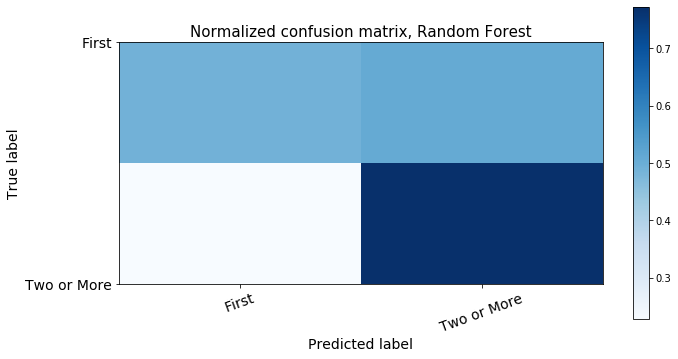

In [42]:
## K-Nearest Neighbors
knn_model_final = KNeighborsClassifier(n_neighbors = 15, n_jobs = 7)
knn_model_final.fit(x_train_sm, np.ravel(y_train, order='C'))
valid_predict_knn_final = knn_model_final.predict(x_test_sm)

class_names = ['First', 'Two or More']

# Compute confusion matrix
cnf_matrix_knn = confusion_matrix(y_test, valid_predict_knn_final)
np.set_printoptions(precision=2) # set NumPy to 2 decimal places

# Plot normalized confusion matrix
plt.figure(figsize=(10,5))
plot_confusion_matrix(cnf_matrix_knn, classes=class_names, normalize=True,
                      title='Normalized confusion matrix, Random Forest')

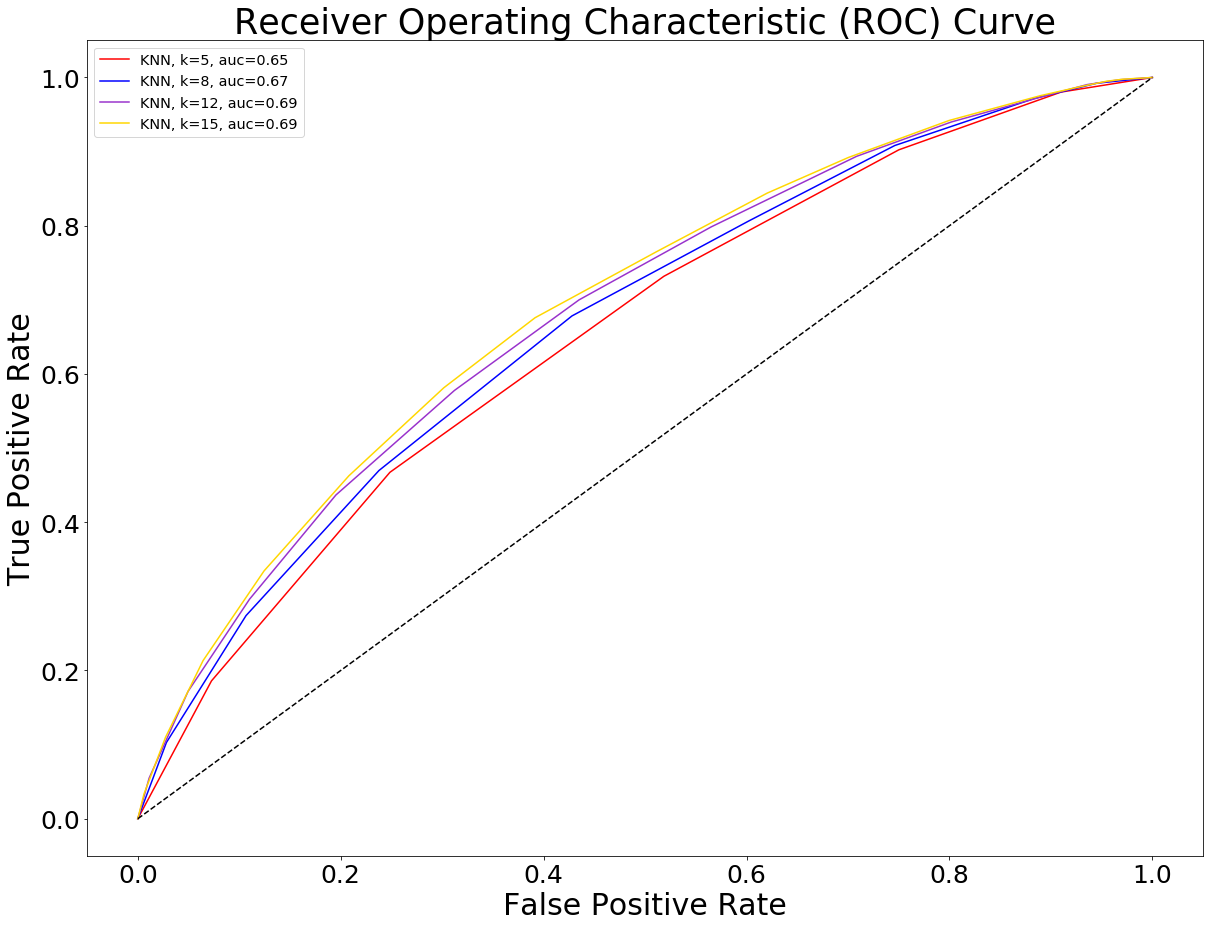

<Figure size 2160x1800 with 0 Axes>

In [44]:
# Building and printing ROC curves for all final models
classes = ['First', 'Two or More']

# k=5
with open("pickle_model_knn_k5.pkl", 'rb') as file:
    knn_model_5 = pickle.load(file)
    
probs5 = knn_model_5.predict_proba(x_validation_sm)
probs5 = probs5[:, 1]

# k=8
with open("pickle_model_knn_k8.pkl", 'rb') as file:
    knn_model_8 = pickle.load(file)
    
probs8 = knn_model_8.predict_proba(x_validation_sm)
probs8 = probs8[:, 1]

# k=12
with open("pickle_model_knn_k12.pkl", 'rb') as file:
    knn_model_12 = pickle.load(file)
    
probs12 = knn_model_12.predict_proba(x_validation_sm)
probs12 = probs12[:, 1]

# k=15
with open("pickle_model_knn_k15.pkl", 'rb') as file:
    knn_model_15 = pickle.load(file)
    
probs15 = knn_model_15.predict_proba(x_validation_sm)
probs15 = probs15[:, 1]

fpr, tpr, thresh = metrics.roc_curve(y_validation, probs5)
auc = metrics.roc_auc_score(y_validation, probs5)
np.set_printoptions(precision=2)
plt.plot(fpr,tpr,label="KNN, k=5, auc="+str(round(auc, 2)), color = 'red')

fpr, tpr, thresh = metrics.roc_curve(y_validation, probs8)
auc = metrics.roc_auc_score(y_validation, probs8)
np.set_printoptions(precision=2)
plt.plot(fpr,tpr,label="KNN, k=8, auc="+str(round(auc, 2)), color = 'blue')

fpr, tpr, thresh = metrics.roc_curve(y_validation, probs12)
auc = metrics.roc_auc_score(y_validation, probs12)
np.set_printoptions(precision=2)
plt.plot(fpr,tpr,label="KNN, k=12, auc="+str(round(auc, 2)), color = 'darkorchid')

fpr, tpr, thresh = metrics.roc_curve(y_validation, probs15)
auc = metrics.roc_auc_score(y_validation, probs15)
np.set_printoptions(precision=2)
plt.plot(fpr,tpr,label="KNN, k=15, auc="+str(round(auc, 2)), color = 'gold')